# Modelling
In this part we experiment with differernt models and strive to get the best performing model

## Import the necessary libraries


In [2]:
# Set configuration for notebook
import os

os.chdir("c:\\Users\\Spectra\\flood-prediction")
os.getcwd()

'c:\\Users\\Spectra\\flood-prediction'

In [3]:
# Import libraries
import mlflow
import optuna
import pandas as pd
import numpy as np
import autogluon as ag
from autogluon.tabular import TabularDataset, TabularPredictor
from src.utils import load_config
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

In [17]:
# load config
config = load_config()

## Modelling

**Run automl to get the best model from which we can build upon**

In [16]:
# Load data
train_data = pd.read_csv(config["data"]["train_data_path"])
label = "Flood"


# Split the data into train and validation sets
train, val = train_test_split(
    train_data, test_size=0.1, stratify=train_data[label], random_state=42
)
train = TabularDataset(train)
val = TabularDataset(val)
# Run AutoML with stratified cross-validation
predictor = TabularPredictor(
    label=label, eval_metric="f1", sample_weight="auto_weight", path="models"
).fit(train_data, presets=["medium_quality", "optimize_for_deployment"])

# Get the leaderboard of models
predictor.leaderboard(val)

Presets specified: ['medium_quality', 'optimize_for_deployment']


Beginning AutoGluon training ...
AutoGluon will save models to "models"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       2.07 GB / 15.85 GB (13.0%)
Disk Space Avail:   103.13 GB / 475.53 GB (21.7%)
Train Data Rows:    16435
Train Data Columns: 8
Label Column:       Flood
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Avai

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.998487,0.935143,f1,0.450269,0.253764,4.966599,0.450269,0.253764,4.966599,1,True,2
1,LightGBM,0.977238,0.941529,f1,0.046250,0.029999,5.796603,0.046250,0.029999,5.796603,1,True,1
2,WeightedEnsemble_L2,0.969605,0.947210,f1,0.677144,0.354860,54.338814,0.007526,0.006037,1.959838,2,True,4
3,NeuralNetFastAI,0.940276,0.933535,f1,0.173100,0.065060,41.615774,0.173100,0.065060,41.615774,1,True,3


In [6]:
predictor.path

'AutogluonModels\\ag-20240522_034459'

In [7]:
import shutil

In [8]:
shutil.move(predictor.path, "models/best_model")

'models/best_model'

In [264]:
predictor = TabularPredictor.load(config["models"]["models_directory"])

predictor.feature_importance(val)

Computing feature importance via permutation shuffling for 8 features using 1644 rows with 5 shuffle sets...
	17.68s	= Expected runtime (3.54s per shuffle set)
	4.82s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Rainfall,0.196502,0.002994,6.463007e-09,5,0.202666,0.190338
rain_latitude,0.134218,0.005535,3.463299e-07,5,0.145615,0.122821
Station_Number,0.063042,0.005205,5.524884e-06,5,0.073758,0.052325
ALT,0.063004,0.002460,2.784880e-07,5,0.068070,0.057938
rain_longitude,0.059763,0.006247,1.412137e-05,5,0.072626,0.046900
dist_to_water,0.056144,0.005500,1.091452e-05,5,0.067469,0.044819
Min_Temp,0.030790,0.004926,7.602393e-05,5,0.040933,0.020647
Cloud_Coverage,0.028832,0.004601,7.528030e-05,5,0.038306,0.019357


Computing feature importance via permutation shuffling for 8 features using 1644 rows with 5 shuffle sets...


	9.44s	= Expected runtime (1.89s per shuffle set)
	5.8s	= Actual runtime (Completed 5 of 5 shuffle sets)


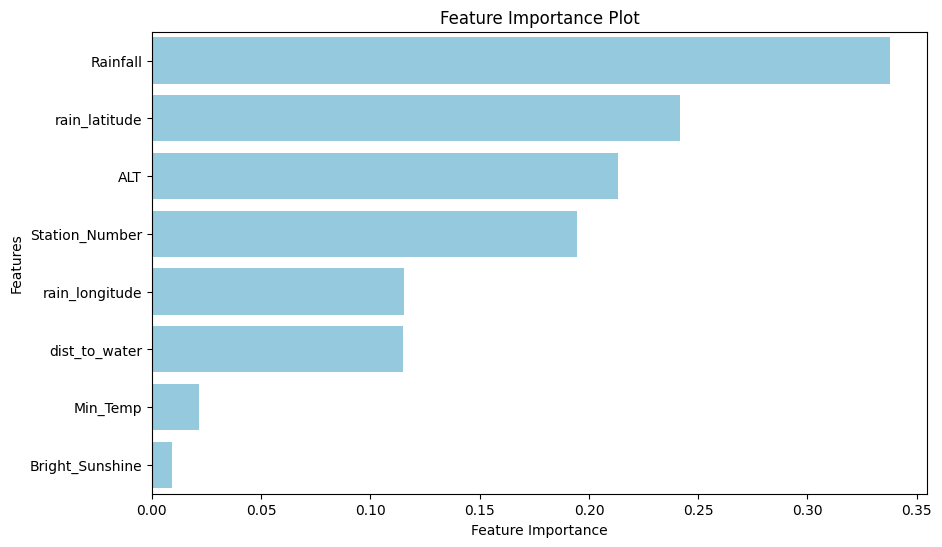

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_importance_df = predictor.feature_importance(val)
# Assuming 'df' is your DataFrame containing the feature importance data
plt.figure(figsize=(10, 6))
sns.barplot(
    x="importance",
    y=feature_importance_df.index,
    data=feature_importance_df,
    color="skyblue",
)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

**Hyperparametertune the model**

**Validate Model on test data**

In [18]:
predictor = TabularPredictor.load(config["modelling"]["models_directory"])

In [13]:
# Load test data
test_data = pd.read_csv(config["data"]["test_data_path"]).drop("Flood", axis=1)
y_true = pd.read_csv(config["data"]["test_data_path"])["Flood"].values
test = TabularDataset(config["data"]["test_data_path"])
test_no_label = TabularDataset(test_data)

Loaded data from: data/testing_data/test.csv | Columns = 9 / 9 | Rows = 4109 -> 4109


In [19]:
predictions = predictor.predict(test_no_label)

In [20]:
perf = predictor.evaluate(test, auxiliary_metrics=False)
perf

{'f1': 0.9390986601705238}

In [279]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3283
           1       0.95      0.94      0.94       826

    accuracy                           0.98      4109
   macro avg       0.97      0.96      0.96      4109
weighted avg       0.98      0.98      0.98      4109



The best model is saved in the folder models.

In [4]:
import os


def print_directory_tree(root_dir):
    print(f"{root_dir}/")
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, "").count(os.sep)
        indent = " " * 4 * level
        subdir = root.split("/")[-1]
        print(f"{indent}├── {subdir}/")
        for file in files:
            print(f"{indent}│   └── {file}")


# Example usage
print_directory_tree("flood-prediction")

flood-prediction/
